# Setting up

First, we will define some global variables and utilities that will be helpful for us. We will consider two types of images:

### Template images
Those images are meant to fulfill some special requirements. They contain the sample cards that will be used to perform matching in query images. Please note that you can replace the template images and change the value of all the variables declared in the following block to make this notebook work with other card decks, as long as these conditions are met:

- Every template image must contain only one card
- Card must be a rectangle
- Card must be in foreground and can be easily distinguished from the background
- At least one corner must have some special symbol on it. It doesn't matter whether it contains the card's suit or rank, as it is only used to calculate correct orientation. Note that this rule is met in a standard french 52-card deck, though we have two corners that match this condition. This is not a problem, as both corners can be used as the top-left corner (cards are moreless symmetric, and we've got some tricks to handle this that we'll see later).

Notice that `card_suits` and `card_ranks` represent the possible suits and ranks that can exist in your deck, and rank don't even have to be numeric. All your images in the `template` folder must follow the naming pattern `{card_suit}_{card_rank}`, unless you modify the `get_card_name()` method to a more convenient one for you.

### Query images
They can be -literally- any image, but you will get better results if they follow this condition:

- Do not overlap cards. Overlapping cards might cause that the card below is not isolated as a full rectangle, and therefore not considered a card.

Please notice that both types of images can be any size and colour, as they are gray scaled and standardized before we use them. This also applies to query images, so there's no problem with arbitrary images :) 

In [580]:
###############################################################################
# Globals
###############################################################################


import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

# Variables you would like to change :)
card_suits = ["clubs", "diamonds", "hearts", "spades"]
card_max_rank = 13
template_card_image_extension = "jpg"
template_path = "../template/"
training_card_image_extension = "png"
training_path = "../training/"
query_path = "../query/"

# Get the standard name for a card given its suit and rank
def get_card_name(card_suit, card_rank):
    return f"{card_suit}_{card_rank}"

# Get the path to the template card given its name
def get_template_card_path(card_name):
    return f"{template_path}{card_name}.{template_card_image_extension}"

# Get the path to the trained card given its name
def get_trained_card_path(card_name):
    return f"{training_path}{card_name}_trained.{training_card_image_extension}"

# Get the path to the card's features file given its name
def get_features_file_path(card_name):
    return f"{training_path}{card_name}.npz"

# Get the path to a query image given its name
def get_query_image_path(file_name):
    return f"{query_path}{file_name}"

# Get a list of card names
cards = [get_card_name(card_suit, card_rank)
         for card_suit in card_suits for card_rank in range(1, card_max_rank + 1)]

## Card detection & feature extraction

In the following block, we will iterate over all template images and we'll try to isolate the corresponding card from the background (depending on the template name). Also, we'll compute and extract features from them to perform feature matching later.

The output will help you have a brief idea of what's going on: each card is processed in two stages, the first one crops and standardizes the card, and the second one computes and extracts features. Any stage can be skipped depending on whether the card is already standardized or whether the features have been already extracted and saved in a file. This way we save our precious time :)

In [581]:
###############################################################################
# Card & feature extraction
###############################################################################


# So you got here. This is where all magic happens. Don't worry, I'll explain
# everything for you to understand what's happening behind the scenes.

# The first thing we need to accomplish in this notebook is to find a way to, given
# an arbitrary image, identify possible cards in it. Looks hard? It is hard to make
# hard things easy, but give me a try :)


# This method is a generator that will try to identify and isolate card-like rectangles
# from a given image. All the returned rectangles are contained in the image, and they
# are returned as binary images that have been straightened using an affinity matrix
def get_potential_cards(image, dst_width=200, dst_height=283, card_min_image_area_percent=0.03, roi_min_image_area_percent=0.001):
    # First, let's binarize the image using Otsu's thresholding.
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    _, thresh_image = cv.threshold(gray_image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    # Now, we get all possible contours in the binarized image.
    contours, _ = cv.findContours(
        thresh_image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    # Not all contours are potential cards: we want them to meet
    # some conditions to avoid unnecesary computations.
    best_card_contours = get_best_card_contours(
        image, contours, card_min_image_area_percent)
    while True:
        best_card_contour = next(best_card_contours)
        if best_card_contour is None:
            break

        # It seems that we've got a potential card in this contour, so
        # let's assume it is so. The card could be rotated, skewed...
        # We'll need to straighten the card so it's top-left corner matches
        # the top-left corner of the result image, as training cards do.

        # We start by isolating the ROI to a new image and getting some
        # information like vertices, bounding rect area, etc.
        roi_x, roi_y, roi_w, roi_h = cv.boundingRect(best_card_contour)
        roi_thresh_image = thresh_image[roi_y:roi_y +
                                        roi_h, roi_x:roi_x + roi_w]
        roi_origin = [roi_x, roi_y]
        roi_vertices = translate_vertices(get_vertices_from_poly(
            get_poly_from_contour(best_card_contour)), roi_origin)

        roi_area = roi_w * roi_h
        roi_min_image_area = roi_area * roi_min_image_area_percent

        # To figure out how to orient the card, we need to find some
        # different corner. We'll get all contours inside the card,
        # with the hope that some contour will be very very close to
        # a corner. The corner with the closest contour to it will be
        # the one that we'll use as the top-left corner, as stated in the former rules.

        # Possible optimization: look only for contours that are in
        # the immediate level to the outermost contour, so we reduce
        # the amount of contours that we iterate over to get the different corner.
        #
        # roi_contours, roi_hierarchies = cv.findContours(
        #   roi_thresh_image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        # roi_external_contour_idx, _ = max(enumerate(roi_contours), key=lambda contour: cv.contourArea(contour[1]))
        # roi_contours = [contour for i, contour in enumerate(roi_contours) if roi_hierarchies[0][i][3] == roi_external_contour_idx]
        #
        # Potential problems:
        # - Might reduce the chance to find the right corner, as we skip some contours
        #   and the one that makes the corner different might be included :)
        # - Might not be computationally worth

        roi_contours, _ = cv.findContours(
            roi_thresh_image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

        # Let's get the corner that has the closest contour to it by taking the distance
        # of the biggest contours to all corners.
        closest_roi_contour_to_vertex = [None for _ in roi_vertices]
        min_distance_roi_contour_to_vertex = [None for _ in roi_vertices]
        for roi_contour in roi_contours:
            if cv.contourArea(roi_contour) < roi_min_image_area:
                continue
            roi_contour_center = get_contour_center(roi_contour)
            for i, roi_vertex in enumerate(roi_vertices):
                roi_contour_distance_to_vertex = fast_euclidean_distance(
                    roi_contour_center, roi_vertex)
                if closest_roi_contour_to_vertex[i] is None or min_distance_roi_contour_to_vertex[i] > roi_contour_distance_to_vertex:
                    closest_roi_contour_to_vertex[i] = roi_contour
                    min_distance_roi_contour_to_vertex[i] = roi_contour_distance_to_vertex

        # The "most useful" vertices are the ones that have closest contours
        # to them. In a french 52-card deck, there are two: the corners with
        # the suit and rank. But we only need one of them, so let's get the one
        # with the closest contour to it.
        roi_useful_vertices_idx = [idx for idx, _ in sorted(
            enumerate(min_distance_roi_contour_to_vertex), key=lambda x: x[1])]
        roi_most_useful_vertex_idx = roi_useful_vertices_idx[0]
        roi_most_useful_vertex = roi_vertices[roi_most_useful_vertex_idx]
        roi_ordered_vertices = [roi_most_useful_vertex]

        # Ok, so we already know which one will be the top-left corner. Now, we
        # need to sort the rest.
        roi_unordered_vertices = [
            roi_vertices[(roi_most_useful_vertex_idx + i) % 4] for i in range(1, 4)]
        # Vertices are contiguous in the array. This means that either the next or the
        # previous vertex must be closer to the top-left vertex, as they form the upper
        # edge of the card. Doing so, we've just figured out if vertices are sorted clockwise
        # or counterclockwise.
        if fast_euclidean_distance(roi_most_useful_vertex, roi_unordered_vertices[2]) < fast_euclidean_distance(roi_most_useful_vertex, roi_unordered_vertices[0]):
            roi_unordered_vertices.reverse()
        roi_ordered_vertices += roi_unordered_vertices

        # We know have all our source vertices labeled. Let's transform the card to
        # de-rotate, de-skew and de-everything it!
        dst_vertices = [[0, 0], [dst_width, 0], [
            dst_width, dst_height], [0, dst_height]]
        transform_matrix = cv.getPerspectiveTransform(
            np.float32(roi_ordered_vertices), np.float32(dst_vertices))
        dst_image = cv.warpPerspective(
            roi_thresh_image, transform_matrix, (dst_width, dst_height))
        _, dst_thresh_image = cv.threshold(dst_image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
        yield dst_thresh_image
    yield None


# This is an auxiliar method to filter out some contours that doesn't
# look like cards at all.
def get_best_card_contours(image, contours, card_min_image_area_percent):
    image_height, image_width, _ = image.shape
    image_area = image_width * image_height

    valid_detailed_contours = []
    for contour in contours:
        # We want cards to have, at least, a moreless acceptable area
        area = cv.contourArea(contour)
        if area < card_min_image_area_percent * image_area:
            continue
        poly = get_poly_from_contour(contour)
        # And we want them to have four vertices... seriously, is that too much to ask?!
        if len(poly) != 4:
            continue
        valid_detailed_contours.append((contour, area))

    # Let's assume the bigger an area is, the better. Of course it could be not,
    # but we rely on cards being a considerable part of the image.
    largest_detailed_contours = sorted(
        valid_detailed_contours, key=lambda detailed_contour: detailed_contour[1], reverse=True)
    for detailed_contour in largest_detailed_contours:
        yield detailed_contour[0]
    yield None


# As soon as we move into a ROI's boundary rect, we need to
# translate its vertices to match the new image's coordinate space
def translate_vertices(vertices, origin):
    return [vertex - origin for vertex in vertices]


# Get a contour's center
def get_contour_center(contour):
    moment = cv.moments(contour)
    return [int(moment["m10"] / moment["m00"]), int(moment["m01"] / moment["m00"])]


# Calculates something similar to the Euclidean distance, but
# without taking the root. This is useful if you don't need the
# real Euclidean distance, but to compare distances that are also
# computed with this method.
def fast_euclidean_distance(vertex1, vertex2):
    return (vertex1[0] - vertex2[0]) ** 2 + (vertex1[1] - vertex2[1]) ** 2


# Approximates a polygon from a given contour
def get_poly_from_contour(contour):
    perimeter = cv.arcLength(contour, True)
    return cv.approxPolyDP(contour, 0.05 * perimeter, True)


# Get the vertices of a polygon. Just a convenience method, nothing else.
def get_vertices_from_poly(poly):
    return [raw_vertex[0] for raw_vertex in poly]


# This method will get the list of cards and will perform the training on them.
# The training consists of:
#  - Getting a potential card of each of the template images
#  - Compute SIFT and ORB features from it and store them
# If any of these steps is already done, then we skip it to save time.
def perform_training():
    changed_cards = set()

    # Those two are feature extractors that we'll use
    sift = cv.SIFT_create()
    orb = cv.ORB_create()

    if not os.path.exists(training_path):
        os.mkdir(training_path)

    for card_name in cards:
        print(f"{card_name}: ", end="")
        template_card_path = get_template_card_path(card_name)
        trained_card_path = get_trained_card_path(card_name)
        if not os.path.exists(trained_card_path):
            card_image = cv.imread(template_card_path)
            trained_card_image = next(get_potential_cards(card_image))
            if trained_card_image is None:
                print(f"No card found, aborting.")
                continue
            cv.imwrite(trained_card_path, trained_card_image)
            # Adding a card to this set means that, even if we've got previous
            # features saved, we need to recompute them and overwrite the current
            # file.
            changed_cards.add(card_name)
            print("Got a new card, ", end="")
        else:
            print("Already got a card, ", end="")
            trained_card_image = cv.imread(trained_card_path)

        features_file_path = get_features_file_path(card_name)
        if not os.path.exists(features_file_path) or card_name in changed_cards:
            print("computed new features.")
            _, sift_features = sift.detectAndCompute(
                trained_card_image, None
            )
            _, orb_features = orb.detectAndCompute(
                trained_card_image, None
            )
            np.savez_compressed(features_file_path, sift_features=sift_features,
                                orb_features=orb_features)
        else:
            print(f"computing features skipped.")
    print("Training complete.")


# Actually performs the training
perform_training()


clubs_1: Already got a card, computing features skipped.
clubs_2: Already got a card, computing features skipped.
clubs_3: Already got a card, computing features skipped.
clubs_4: Already got a card, computing features skipped.
clubs_5: Already got a card, computing features skipped.
clubs_6: Already got a card, computing features skipped.
clubs_7: Already got a card, computing features skipped.
clubs_8: Already got a card, computing features skipped.
clubs_9: Already got a card, computing features skipped.
clubs_10: Already got a card, computing features skipped.
clubs_11: Already got a card, computing features skipped.
clubs_12: Already got a card, computing features skipped.
clubs_13: Already got a card, computing features skipped.
diamonds_1: Already got a card, computing features skipped.
diamonds_2: Already got a card, computing features skipped.
diamonds_3: Already got a card, computing features skipped.
diamonds_4: Already got a card, computing features skipped.
diamonds_5: Alr

# Matching cards

At this point, we have all we need to run playing card matching on arbitrary images. But first, we need to load all the stuff we have computed previously.
First, let's load the features we have computed (for feature matching) as well as the trained card images (for template matching).

In [582]:
###############################################################################
# Load features & training cards
###############################################################################


training_features = {
    "sift_features": dict(),
    "orb_features": dict()
}
training_cards = {
    "regular": dict(),
    "upsidedown": dict()
}

for card_name in cards:
    with np.load(get_features_file_path(card_name), allow_pickle=True) as raw_features:
        training_features["sift_features"][card_name] = np.copy(
            raw_features["sift_features"])
        training_features["orb_features"][card_name] = np.copy(
            raw_features["orb_features"])
    training_cards["regular"][card_name] = cv.cvtColor(cv.imread(get_trained_card_path(card_name)), cv.COLOR_BGR2GRAY)
    training_cards["upsidedown"][card_name] = cv.rotate(training_cards["regular"][card_name], cv.ROTATE_180)


Now, let's define the utilities and abstract algorithms that we'll use to apply matching. 

In [591]:
###############################################################################
# Abstract matching algorithms & utilities
###############################################################################


# SIFT and ORB feature extractors
sift = cv.SIFT_create()
orb = cv.ORB_create()


# Flann feature matcher for SIFT
# (see https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html)
FLANN_INDEX_KDTREE = 1
flann_for_sift_index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
flann_for_sift = cv.FlannBasedMatcher(flann_for_sift_index_params, dict())


# Flann feature matcher for ORB
FLANN_INDEX_LSH = 6
flann_for_orb_index_params = dict(algorithm=FLANN_INDEX_LSH,
                                  table_number=6,
                                  key_size=12,
                                  multi_probe_level=1)
flann_for_orb = cv.FlannBasedMatcher(flann_for_orb_index_params, dict())


# Brute-force feature matcher for SIFT
bf_for_sift = cv.BFMatcher()


# Brute-force feature matcher for ORB
bf_for_orb = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)


# For matchers that use K-nn, this filter allows to
# choose the best matches from a given list. Each match
# is given as the closest and second closest distance between
# features (lower is better). A large difference between the first
# and the second distance implies an unambiguous match.
def pass_good_matches(matches, threshold=0.7):
    good_matches = []
    for n, m in matches:
        if n.distance < m.distance * threshold:
            good_matches.append([n, m])
    return good_matches


# Identity function
def pass_all_matches(matches):
    return matches


# This function will use OpenCV to perform template matching.
# It also works for computing the similarity between two images
# of the same size, as in this case.
def template_matcher(image, template, mode = cv.TM_CCOEFF_NORMED):
    matrix = cv.matchTemplate(image, template, mode)
    min_val, max_val, _, _ = cv.minMaxLoc(matrix)
    if mode in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        return min_val
    else:
        return max_val


# Algorithm to apply descriptor matching. For each image, it will take
# a potential card, extract its features, compute the score of the matching
# between it and every training card, and return the best match.
def match_cards_by_features(query_image, features, feature_extractor, matcher, match_filter=pass_all_matches, match_scorer=len):
    potential_cards = get_potential_cards(query_image)
    while True:
        potential_card = next(potential_cards)
        if potential_card is None:
            break

        _, query_features = feature_extractor(potential_card)
        card_matches = {
            card_name: match_filter(
                matcher(
                    query_features, features[card_name]
                ),
            ) for card_name in cards
        }
        scored_card_matches = {
            card_name: match_scorer(matches) for card_name, matches in card_matches.items()
        }
        match_name = max(scored_card_matches,
                         key=lambda key: scored_card_matches[key])
        match_score = scored_card_matches[match_name]
        yield (potential_card, match_name, match_score)
    yield None


# Algorithm to apply template matching. For each image, it will take
# a potential card, compute the score of the comparison between it and
# every training card, and return the best match.
def match_cards_by_template(query_image, training_cards, matcher, get_best):
    potential_cards = get_potential_cards(query_image)
    while True:
        potential_card = next(potential_cards)
        if potential_card is None:
            break

        scored_card_comparisons = {
            f"{card_name}.{orientation}": matcher(potential_card, training_cards[orientation][card_name])
            for orientation in ["regular", "upsidedown"]
            for card_name in cards
        }
        match_name = get_best(scored_card_comparisons, key=lambda key: scored_card_comparisons[key])
        generic_match_name = match_name.split(".")[0]
        match_score = scored_card_comparisons[match_name]
        yield (potential_card, generic_match_name, match_score)
    yield None


# Algorithm for getting valid matches. As our algorithm to detect potential cards
# is a generator (i.e. it will return a card each time it is called, until it is exhausted),
# we need some criteria to stop getting potential cards after we get 'n' bad results in a row.
def get_valid_card_matches(card_matches, score_validator, max_failed_attempts=3):
    failed_attempts = 0
    valid_card_matches = []
    while True:
        card_match = next(card_matches)
        if card_match is None:
            break

        _, _, match_score = card_match
        if not score_validator(match_score):
            failed_attempts += 1
            if failed_attempts >= max_failed_attempts:
                break
        else:
            valid_card_matches.append(card_match)
    return valid_card_matches


# This method will get a list of matched cards and will display it in a more convenient way
def show_card_matches(query_image, training_cards, card_matches):
    plt.title("Query image")
    plt.imshow(cv.cvtColor(query_image, cv.COLOR_BGR2RGB))
    plt.show()

    if len(card_matches) == 0:
        print("No matches found!")
    else:
        for i, (card_image, card_name, match_score) in enumerate(card_matches):
            plt.subplot(121)
            plt.title(f"Detected card")
            plt.imshow(card_image, cmap="gray")
            plt.subplot(122)
            plt.title(f"Best match: {card_name} (score: {round(match_score, 2)})")
            plt.imshow(training_cards[card_name], cmap="gray")
            plt.show()


### Playing card detection using feature matching

This is the final step. Here, we load a query image and we try to match all all the potential card. In this case, we'll use feature matching. As you might have noticed before, all the code is pluggable as it is mostly written into functions that follow some kind of interfaces. This way, you can also write your own functions that will be plugged in the abstract algorithms and modify their behaviour.

There are a lot of possible combinations!

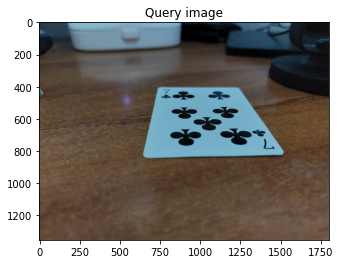

No matches found!


In [605]:
query_image = cv.imread(get_query_image_path("q16.jpg"))

card_matches = match_cards_by_features(
    query_image,
    training_features["sift_features"],
    lambda potential_card: sift.detectAndCompute(potential_card, None),
    lambda features1, features2: flann_for_sift.knnMatch(
        features1, features2, k=2),
    lambda matches: pass_good_matches(matches, threshold=0.70)
)

valid_card_matches = get_valid_card_matches(card_matches, lambda score: score > 20)
show_card_matches(query_image, training_cards["regular"], valid_card_matches)

### Playing card detection using template matching

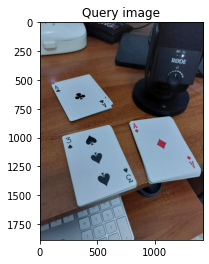

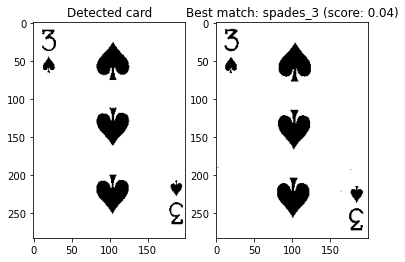

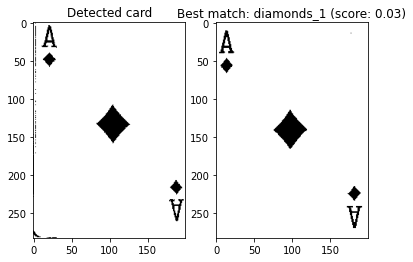

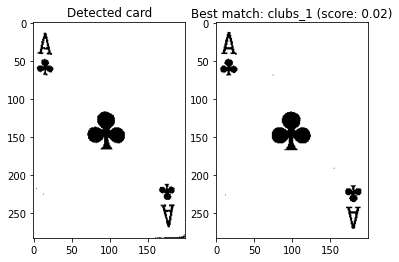

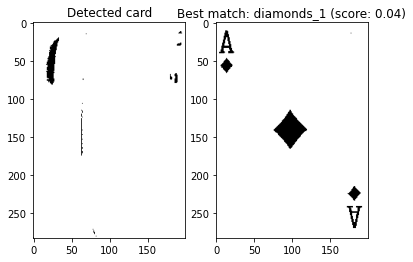

In [606]:
query_image = cv.imread(get_query_image_path("q17.jpg"))

card_matches = match_cards_by_template(
    query_image,
    training_cards,
    lambda image1, image2: template_matcher(image1, image2, cv.TM_SQDIFF_NORMED),
    min
)

valid_card_matches = get_valid_card_matches(card_matches, lambda score: score < 0.1)
show_card_matches(query_image, training_cards["regular"], valid_card_matches)
